In [1]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

mkdir: cannot create directory ‘data_faces’: File exists


In [2]:
import zipfile

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [17]:
import os
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [18]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.utils import make_grid

import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


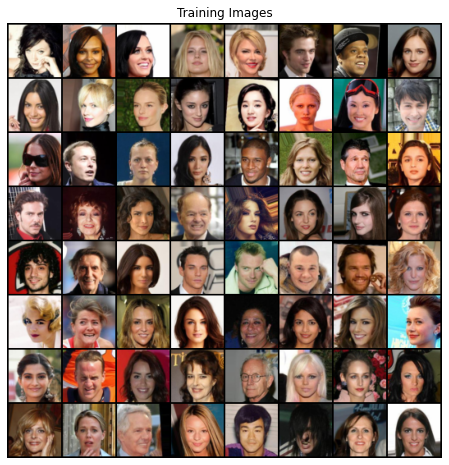

In [19]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
ngpu = 1
crop_size = 108
re_size = 64
offset_height = (218 - crop_size) // 2
offset_width = (178 - crop_size) // 2
crop = lambda x: x[:, offset_height:offset_height + crop_size, offset_width:offset_width + crop_size]

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = datasets.ImageFolder('./data_faces', transform=transform)
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=4)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [20]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [21]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, starting_shape):
        super(Generator, self).__init__()
        self.fc = nn.Linear(starting_shape, 8 * 8 * 128)
        self.upsample_and_generate = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1, bias=True),
            nn.Tanh()
        )
    def forward(self, input):
        transformed_random_noise = self.fc(input)
        reshaped_to_image = transformed_random_noise.reshape((-1, 128, 8, 8))
        generated_image = self.upsample_and_generate(reshaped_to_image)
        return generated_image

In [22]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1, bias=True),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Sigmoid()
        )
        self.fc = nn.Linear(8 * 8 * 128, 1)
    def forward(self, input):
        downsampled_image = self.downsample(input)
        reshaped_for_fc = downsampled_image.reshape((-1, 8 * 8 * 128))
        classification_probs = self.fc(reshaped_for_fc)
        return classification_probs

In [23]:
# Use this to put tensors on GPU/CPU automatically when defining tensors
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

class GAN(nn.Module):

    def __init__(self):
        super(GAN, self).__init__()
        self.num_epoch = 5
        self.batch_size = 128
        self.log_step = 100 
        self.visualize_step = 1
        self.nz = 100  # Intermediate feature shape - latent variable shape
        self.learning_rate = 0.0002
        self.vis_learning_rate = 1e-2
        
        # Sample from Gaussian
        self.tracked_noise = torch.randn([64, self.nz], device=device)        
        
        self._actmax_label = torch.ones([64, 1], device=device)
        
        ################################################################################
        # L2 Loss function                                
        ################################################################################
        
        self._l2_loss = nn.MSELoss()

        ################################################################################
        # Generator, Discriminator and weight Initialization
        ################################################################################

        self._discriminator = Discriminator()
        self._discriminator.to(device)
        self._generator = Generator(self.nz)
        self._generator.to(device)
        
#         self._classification_loss = nn.BCELoss()

        self._classification_loss = nn.BCEWithLogitsLoss()

        # Apply weight initialization here
        self._weight_initialization(self._discriminator)
        self._weight_initialization(self._generator)

        ################################################################################
        # Optimizers - Adam for both Generator and Discriminator
        ################################################################################
        betas = (0.5, 0.999)
        self._generator_optimizer = torch.optim.Adam(self._generator.parameters(), lr=self.learning_rate, betas=betas) 
        self._discriminator_optimizer = torch.optim.Adam(self._discriminator.parameters(), lr=self.learning_rate, betas=betas) 

    def _weight_initialization(self, m):
        # custom weights initialization
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

    def _loss(self, logits, labels):
        return self._classification_loss(logits, labels)

    def _reconstruction_loss(self, generated, target):
        return self._l2_loss(generated, target)

    def train(self):
        # smooth the loss curve so that it does not fluctuate too much
        smooth_factor = 0.95
        plot_dis_s = 0
        plot_gen_s = 0
        plot_ws = 0
        
        dis_losses = []
        gen_losses = []
        self._generator.train()
        self._discriminator.train()
        print('Start training ...')
        for epoch in range(self.num_epoch):
            for i, data in enumerate(dataloader):
                batch_samples,_ = data
                batch_samples = batch_samples
                batch_samples = torch.Tensor(batch_samples).to(device)
                
                fake_label = torch.zeros([len(batch_samples), 1], device=device)
                real_label = torch.ones([len(batch_samples), 1], device=device)
                    
                ################################################################################
                # DISCRIMINATOR - REAL IMAGES
                ################################################################################
                real_dis_out = self._discriminator(batch_samples)
                real_dis_loss = self._loss(real_dis_out, real_label)

                # Real discriminator loss gradients
                self._discriminator_optimizer.zero_grad()
                real_dis_loss.backward()

                ################################################################################
                # DISCRIMINATOR - FAKE IMAGES                 
                ################################################################################                
                noise = torch.randn([len(batch_samples), self.nz], device=device)    # IID Normal(0, 1)^d on the torch device
                
                fake_samples = self._generator(noise)
                # Dtach the fake samples from the gradient calculation 
                # when feeding to the discriminator, we don't want the discriminator to 
                # receive gradient info from the Generator
                fake_dis_out = self._discriminator(fake_samples.detach())
                fake_dis_loss = self._loss(fake_dis_out, fake_label)
                
                # Fake discriminator loss gradients
                fake_dis_loss.backward()

                # Update the discriminator weights
                self._discriminator_optimizer.step()
                
                ################################################################################
                # GENERATOR
                ################################################################################                

                fake_dis_out = self._discriminator(self._generator(torch.randn([len(batch_samples), self.nz], device=device)))
                    
                gen_loss = self._loss(fake_dis_out, real_label)

                # Calculate the generator loss gradients
                self._generator_optimizer.zero_grad()
                gen_loss.backward()

                # Update the generator weights
                self._generator_optimizer.step()
                
                # Total Discriminator Loss = Real_image_dis_loss + Fake_image_discriminator_loss

                dis_loss = real_dis_loss + fake_dis_loss
                
                # Output training stats
                if i % 50 == 0:
                    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'% (epoch, self.num_epoch,dis_loss,gen_loss))
                  
                     
        
                plot_dis_s = plot_dis_s * smooth_factor + dis_loss * (1 - smooth_factor)
                plot_gen_s = plot_gen_s * smooth_factor + gen_loss * (1 - smooth_factor)
                plot_ws = plot_ws * smooth_factor + (1 - smooth_factor)
                dis_losses.append(plot_dis_s / plot_ws)
                gen_losses.append(plot_gen_s / plot_ws)
                
            if epoch % self.visualize_step == 0:
                fig = plt.figure(figsize = (8, 8))   
                ax1 = plt.subplot(111)
                ax1.imshow(make_grid(self._generator(self.tracked_noise.detach()).cpu().detach(), padding=1, normalize=True).numpy().transpose((1, 2, 0)))
                plt.show()

                plt.plot(dis_losses)
                plt.title('discriminator loss')
                plt.xlabel('iterations')
                plt.ylabel('loss')
                plt.show()
    
                plt.plot(gen_losses)
                plt.title('generator loss')
                plt.xlabel('iterations')
                plt.ylabel('loss')
                plt.show()
        print('... Done!')

    # Find the reconstruction of a batch of samples
    def reconstruct(self, samples):
        recon_code = torch.zeros([samples.shape[0], self.nz], device=device, requires_grad=True)
        samples = torch.tensor(samples, device=device, dtype=torch.float32)

        # Set the generator to evaluation mode, to make batchnorm stats stay fixed
        self._generator.eval()

        recon_optimizer = torch.optim.Adam([recon_code], lr=self.vis_learning_rate)
        
        for i in range(500):
            ################################################################################
            # TRAINING LOOP FOR RECONSTRUCTION/VALIDATION
            ################################################################################
            recon_optimizer.zero_grad()
            recon_samples = self._generator(recon_code)
            recon_loss = self._reconstruction_loss(recon_samples, samples)
            recon_loss.backward()
            recon_optimizer.step()

        return recon_loss, recon_samples.detach().cpu()
        

    # Perform activation maximization on a batch of different initial codes
    def actmax(self, actmax_code):
        self._generator.eval()
        self._discriminator.eval() 
        ################################################################################
        # Modifying/Updating the Inputs based on the gradients and not the model, hence the optimizer's first arg is input
        ################################################################################
        actmax_code = torch.tensor(actmax_code, device=device, dtype=torch.float32, requires_grad=True)
        actmax_optimizer = torch.optim.Adam([actmax_code], lr=self.vis_learning_rate)
        for i in range(500):
            actmax_optimizer.zero_grad()
            actmax_sample = self._generator(actmax_code)
            actmax_dis = self._discriminator(actmax_sample)
            actmax_loss = self._loss(actmax_dis, self._actmax_label)
            actmax_loss.backward()
            actmax_optimizer.step()
        return actmax_sample.detach().cpu()

Start training ...
[0/5]	Loss_D: 1.3635	Loss_G: 1.1730
[0/5]	Loss_D: 0.4268	Loss_G: 1.9599
[0/5]	Loss_D: 0.1479	Loss_G: 3.2695
[0/5]	Loss_D: 0.5818	Loss_G: 3.4531
[0/5]	Loss_D: 0.4428	Loss_G: 1.9389
[0/5]	Loss_D: 0.6459	Loss_G: 1.8282
[0/5]	Loss_D: 0.6035	Loss_G: 1.3373
[0/5]	Loss_D: 0.7814	Loss_G: 2.9606
[0/5]	Loss_D: 0.3824	Loss_G: 2.1031
[0/5]	Loss_D: 0.3636	Loss_G: 2.2923
[0/5]	Loss_D: 0.3396	Loss_G: 2.5188
[0/5]	Loss_D: 0.4619	Loss_G: 2.8986
[0/5]	Loss_D: 0.4107	Loss_G: 1.8689
[0/5]	Loss_D: 0.3985	Loss_G: 2.3026
[0/5]	Loss_D: 0.3630	Loss_G: 1.9938
[0/5]	Loss_D: 0.4502	Loss_G: 2.0163
[0/5]	Loss_D: 0.8268	Loss_G: 1.2356
[0/5]	Loss_D: 0.5400	Loss_G: 1.6364
[0/5]	Loss_D: 0.4806	Loss_G: 1.8837
[0/5]	Loss_D: 0.4075	Loss_G: 1.7257
[0/5]	Loss_D: 0.3567	Loss_G: 1.9798
[0/5]	Loss_D: 0.5074	Loss_G: 1.4611
[0/5]	Loss_D: 0.4783	Loss_G: 1.6784
[0/5]	Loss_D: 0.5525	Loss_G: 1.1489
[0/5]	Loss_D: 0.5712	Loss_G: 2.4207
[0/5]	Loss_D: 0.7523	Loss_G: 0.9251
[0/5]	Loss_D: 0.6632	Loss_G: 2.7059
[0/5]	Los

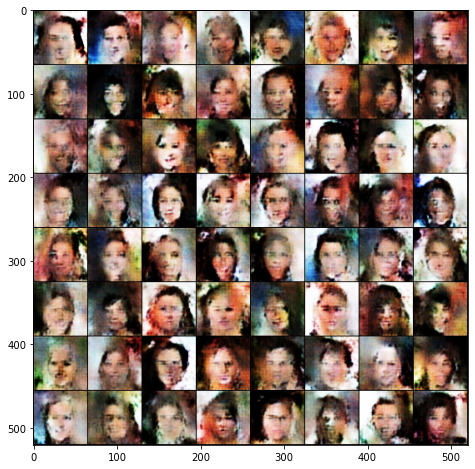

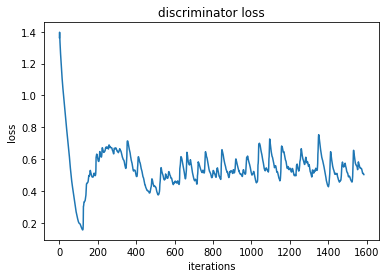

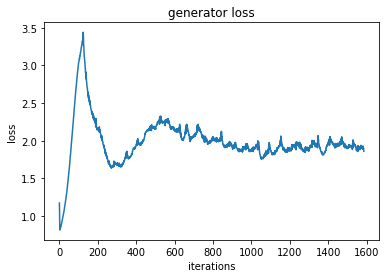

[1/5]	Loss_D: 0.5378	Loss_G: 3.0413
[1/5]	Loss_D: 0.4536	Loss_G: 1.8309
[1/5]	Loss_D: 0.5037	Loss_G: 2.9172
[1/5]	Loss_D: 0.4328	Loss_G: 1.4755
[1/5]	Loss_D: 0.5248	Loss_G: 1.1607
[1/5]	Loss_D: 0.7633	Loss_G: 2.2174
[1/5]	Loss_D: 0.5247	Loss_G: 1.3233
[1/5]	Loss_D: 0.4648	Loss_G: 1.6190
[1/5]	Loss_D: 0.4533	Loss_G: 1.9416
[1/5]	Loss_D: 0.5911	Loss_G: 2.3048
[1/5]	Loss_D: 1.0095	Loss_G: 0.9378
[1/5]	Loss_D: 0.4617	Loss_G: 2.0850
[1/5]	Loss_D: 0.4747	Loss_G: 2.0611
[1/5]	Loss_D: 0.4102	Loss_G: 1.6078
[1/5]	Loss_D: 0.6700	Loss_G: 0.9747
[1/5]	Loss_D: 0.5167	Loss_G: 1.6943
[1/5]	Loss_D: 0.4753	Loss_G: 1.7670
[1/5]	Loss_D: 0.4517	Loss_G: 1.8107
[1/5]	Loss_D: 0.4379	Loss_G: 1.7541
[1/5]	Loss_D: 0.6062	Loss_G: 1.0824
[1/5]	Loss_D: 0.3921	Loss_G: 2.1573
[1/5]	Loss_D: 0.4744	Loss_G: 1.6322
[1/5]	Loss_D: 0.8818	Loss_G: 1.0098
[1/5]	Loss_D: 0.4479	Loss_G: 1.6503
[1/5]	Loss_D: 0.4679	Loss_G: 1.7305
[1/5]	Loss_D: 0.6411	Loss_G: 2.6457
[1/5]	Loss_D: 1.0020	Loss_G: 0.8215
[1/5]	Loss_D: 0.4030	Loss_G:

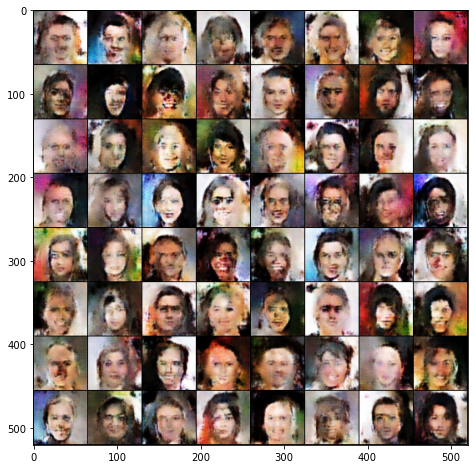

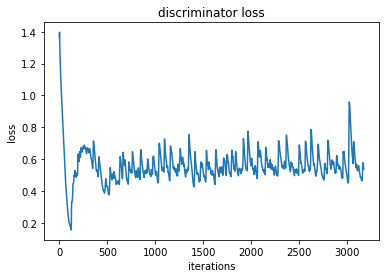

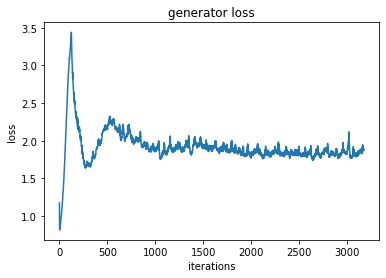

[2/5]	Loss_D: 0.4451	Loss_G: 1.5342
[2/5]	Loss_D: 0.4110	Loss_G: 1.6072
[2/5]	Loss_D: 0.4833	Loss_G: 1.8141
[2/5]	Loss_D: 0.4248	Loss_G: 1.7685
[2/5]	Loss_D: 0.6498	Loss_G: 3.2088
[2/5]	Loss_D: 0.8047	Loss_G: 0.9193
[2/5]	Loss_D: 0.5950	Loss_G: 1.3917
[2/5]	Loss_D: 0.4151	Loss_G: 1.6179
[2/5]	Loss_D: 0.5767	Loss_G: 1.9205
[2/5]	Loss_D: 0.4510	Loss_G: 1.4935
[2/5]	Loss_D: 0.8335	Loss_G: 2.7216
[2/5]	Loss_D: 0.4903	Loss_G: 1.8987
[2/5]	Loss_D: 0.5348	Loss_G: 2.3513
[2/5]	Loss_D: 0.3663	Loss_G: 2.3910
[2/5]	Loss_D: 0.4299	Loss_G: 2.1515
[2/5]	Loss_D: 0.4196	Loss_G: 2.2951
[2/5]	Loss_D: 0.4977	Loss_G: 2.5714
[2/5]	Loss_D: 0.3988	Loss_G: 1.3335
[2/5]	Loss_D: 0.5177	Loss_G: 1.6305
[2/5]	Loss_D: 0.5243	Loss_G: 1.5286
[2/5]	Loss_D: 0.4317	Loss_G: 2.3250
[2/5]	Loss_D: 0.3725	Loss_G: 1.9038
[2/5]	Loss_D: 0.6747	Loss_G: 0.9815
[2/5]	Loss_D: 0.4599	Loss_G: 2.6293
[2/5]	Loss_D: 0.3763	Loss_G: 2.2012
[2/5]	Loss_D: 0.4752	Loss_G: 1.9412
[2/5]	Loss_D: 0.3810	Loss_G: 1.7119
[2/5]	Loss_D: 0.3834	Loss_G:

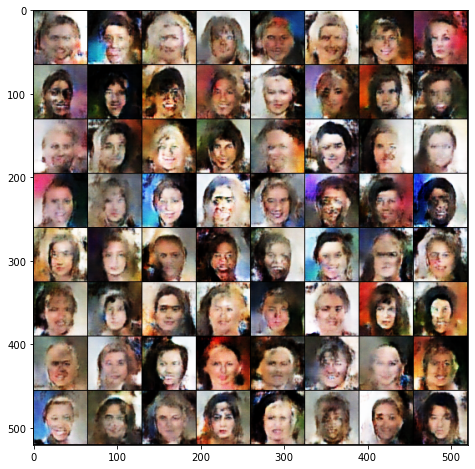

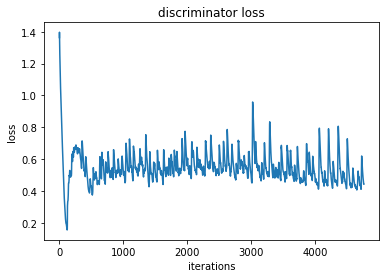

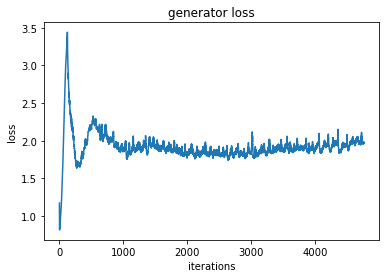

[3/5]	Loss_D: 0.4453	Loss_G: 1.7409
[3/5]	Loss_D: 0.4378	Loss_G: 1.7151
[3/5]	Loss_D: 0.4035	Loss_G: 1.9523
[3/5]	Loss_D: 0.3991	Loss_G: 2.2353
[3/5]	Loss_D: 0.3944	Loss_G: 1.6592
[3/5]	Loss_D: 0.5769	Loss_G: 1.3885
[3/5]	Loss_D: 0.4172	Loss_G: 2.7662
[3/5]	Loss_D: 0.3687	Loss_G: 2.3811
[3/5]	Loss_D: 0.5668	Loss_G: 1.5353
[3/5]	Loss_D: 0.3656	Loss_G: 1.6407
[3/5]	Loss_D: 0.3601	Loss_G: 2.3166
[3/5]	Loss_D: 0.6313	Loss_G: 2.3377
[3/5]	Loss_D: 0.3936	Loss_G: 1.7665
[3/5]	Loss_D: 0.3775	Loss_G: 1.7663
[3/5]	Loss_D: 0.2979	Loss_G: 2.1513
[3/5]	Loss_D: 0.4984	Loss_G: 1.4294
[3/5]	Loss_D: 0.4288	Loss_G: 1.8736
[3/5]	Loss_D: 0.3205	Loss_G: 2.1454
[3/5]	Loss_D: 0.3781	Loss_G: 1.5713
[3/5]	Loss_D: 0.3828	Loss_G: 2.9067
[3/5]	Loss_D: 0.4378	Loss_G: 1.6826
[3/5]	Loss_D: 0.3614	Loss_G: 1.7370
[3/5]	Loss_D: 0.3974	Loss_G: 1.6555
[3/5]	Loss_D: 0.3693	Loss_G: 2.4899
[3/5]	Loss_D: 0.7282	Loss_G: 3.8355
[3/5]	Loss_D: 0.3539	Loss_G: 2.1270
[3/5]	Loss_D: 0.3611	Loss_G: 1.6552
[3/5]	Loss_D: 0.5332	Loss_G:

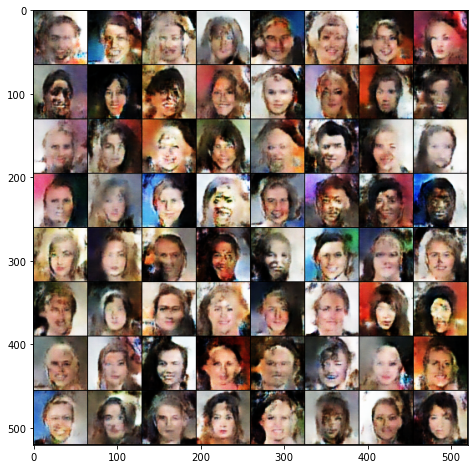

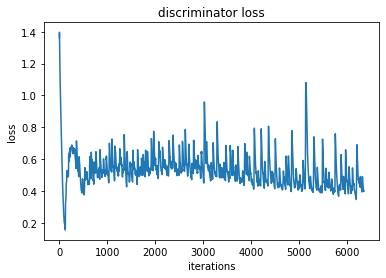

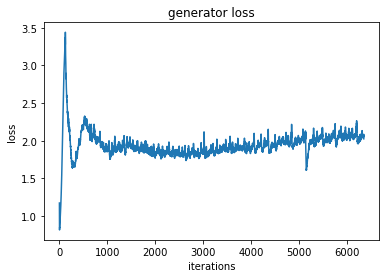

[4/5]	Loss_D: 0.8986	Loss_G: 4.6840
[4/5]	Loss_D: 0.3194	Loss_G: 1.9580
[4/5]	Loss_D: 0.3500	Loss_G: 2.1249
[4/5]	Loss_D: 0.3864	Loss_G: 2.1042
[4/5]	Loss_D: 0.3176	Loss_G: 2.2036
[4/5]	Loss_D: 0.3241	Loss_G: 2.2005
[4/5]	Loss_D: 0.3836	Loss_G: 1.9822
[4/5]	Loss_D: 0.4487	Loss_G: 2.3184
[4/5]	Loss_D: 0.3160	Loss_G: 2.4812
[4/5]	Loss_D: 0.3023	Loss_G: 2.5161
[4/5]	Loss_D: 0.5698	Loss_G: 3.4442
[4/5]	Loss_D: 0.2848	Loss_G: 2.6860
[4/5]	Loss_D: 0.3588	Loss_G: 3.1263
[4/5]	Loss_D: 0.3649	Loss_G: 2.1523
[4/5]	Loss_D: 0.4356	Loss_G: 1.8595
[4/5]	Loss_D: 0.4379	Loss_G: 1.5540
[4/5]	Loss_D: 0.3642	Loss_G: 1.5900
[4/5]	Loss_D: 1.0944	Loss_G: 1.1123
[4/5]	Loss_D: 0.3930	Loss_G: 2.4348
[4/5]	Loss_D: 0.4061	Loss_G: 2.5056
[4/5]	Loss_D: 0.7496	Loss_G: 1.0907
[4/5]	Loss_D: 0.3955	Loss_G: 2.3172
[4/5]	Loss_D: 0.3713	Loss_G: 1.8913
[4/5]	Loss_D: 0.3649	Loss_G: 2.7756
[4/5]	Loss_D: 0.7069	Loss_G: 1.0080
[4/5]	Loss_D: 0.3516	Loss_G: 2.0575
[4/5]	Loss_D: 0.4047	Loss_G: 1.9789
[4/5]	Loss_D: 0.3506	Loss_G:

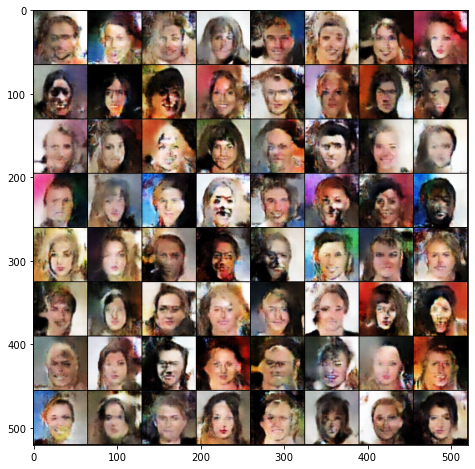

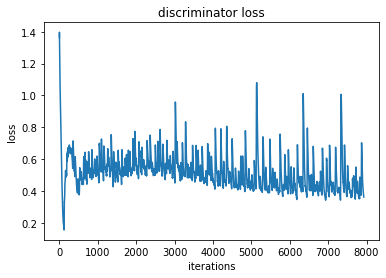

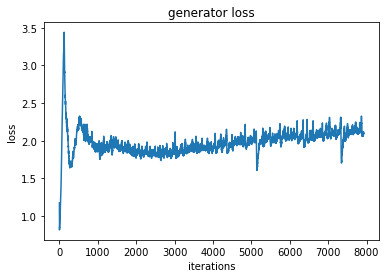

... Done!


In [24]:
gan = GAN()
gan.train()
torch.save(gan.state_dict(), "dcgan.pt")